# Term Deposit Marketing 2
## Introduction
- Prior to reading this notebook, see **notebook_1.ipynb** for **Data wrangling, Exploratory data analysis, Data visualization, Model creation and Model evaluation**.
- As a reminder, **CatBoostClassifier, LGBMClassifier, RandomForestClassifier, XGBClassifier and DecisionTreeClassifier** all surpassed the goal of **81% test accuracy** with **CatBoostClassifier and RandomForestClassifier** producing the best results of **~87%** test accuracy each.
- These models have been saved in the models folder of this project repository.
- This notebook will tackle **Feature Importance** and **Customer Segmentation**.

### Libraries

In [35]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from operator import itemgetter
import missingno as msno
import plotly.express as px

# Models imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lazypredict.Supervised import LazyClassifier

# Warnings imports
from warnings import filterwarnings
filterwarnings("ignore")

# Sklearn imports
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Other imports
import shap
from scipy.special import softmax
from itertools import permutations
import itertools

### Helper function(s)

In [36]:
# Prints a horizontal line for delineating outputs
def barrier():
    print("\n <<<", "-"*50, ">>> \n")

# Saves models
def save_model(model, name):
    with open("models/" + name + ".pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"Model: {name}.pkl saved.")

# Loads models
def load_model(name):
    with open("models/" + name, "rb") as f:
        model = pickle.load(f)
    return model

# Saves models
def save_model_dropped(model, name):
    with open("models_dropped/" + name + ".pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"Model: {name}.pkl saved.")

# Loads models
def load_model_dropped(name):
    with open("models_dropped/" + name, "rb") as f:
        model = pickle.load(f)
    return model

# Emboldening text
def print_bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    print(start + str(text) + end)

# Emboldening text
def bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    return start + str(text) + end

# Print unique values in each column/feature
def print_uniques(df):
    for feature in df.columns:
        print(feature, "------>", df[feature].unique())

# Replace nan with randomly sampled values from each features
def na_random_fill(series):
    na_mask = pd.isnull(series)
    n_null = na_mask.sum()
    if n_null == 0:
        return series
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)
    fill_values.index = series.index[na_mask]
    return series.fillna(fill_values)

## Data

In [37]:
df = pd.read_csv("raw_data.csv")

# Replacing unknown values using random imputation
df.replace("unknown", np.nan, inplace=True)
df["job"] = na_random_fill(df["job"])
df["education"] = na_random_fill(df["education"])
df["contact"] = na_random_fill(df["contact"])

# Label encoding
features = df.select_dtypes("object").columns
df_enc = df.copy()
df_enc[features] = df_enc[features].apply(lambda ser:pd.Series(LabelEncoder().fit_transform(ser), index=ser.index))

# Balancing terget feature with random sampling
ones = df_enc[df_enc["y"] == 1]
zeros = df_enc[df_enc["y"] == 0].sample(n=2896)
df_enc_balanced = pd.concat([ones, zeros]).reset_index(drop=True)

# Train, test sets
RANDOM_STATE = 42
X = df_enc_balanced.drop("y", axis=1)
y = df_enc_balanced["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

# Features
features = X.columns

### Important note
- We did not perform one-hot encoding because we want each feature to be evaluated holistically without becoming too granular.

## Models

In [38]:
# Load saved models
DTC_feat_imp = load_model("DTC.pkl")
RF_feat_imp = load_model("RF.pkl")
XGB_feat_imp = load_model("XGB.pkl")
CAT_feat_imp = load_model("CAT.pkl")
LGBM_feat_imp = load_model("LGBM.pkl")

models_ = [DTC_feat_imp, RF_feat_imp, XGB_feat_imp, CAT_feat_imp, LGBM_feat_imp]
models = [clone(model) for model in models_]

for model in models:
    names = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print_bold(names + ":" )
    print(f"Test accuracy: {acc}")
    barrier()

DecisionTreeClassifier:
Test accuracy: 0.8176064441887226

 <<< -------------------------------------------------- >>> 

RandomForestClassifier:
Test accuracy: 0.8481012658227848

 <<< -------------------------------------------------- >>> 

XGBClassifier:
Test accuracy: 0.8469505178365938

 <<< -------------------------------------------------- >>> 

CatBoostClassifier:
Test accuracy: 0.8855005753739931

 <<< -------------------------------------------------- >>> 

LGBMClassifier:
Test accuracy: 0.8803222094361335

 <<< -------------------------------------------------- >>> 



In [39]:
# A reminder of the different dataframes we have created so far
display(df.head())
barrier()
display(df_enc.head())
barrier()
display(df_enc_balanced.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,no
3,47,blue-collar,married,primary,no,1506,yes,no,cellular,5,may,92,1,no
4,33,admin,single,tertiary,no,1,no,no,cellular,5,may,198,1,no



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,0
1,44,9,2,1,0,29,1,0,0,5,8,151,1,0
2,33,2,1,1,0,2,1,1,0,5,8,76,1,0
3,47,1,1,0,0,1506,1,0,0,5,8,92,1,0
4,33,0,2,2,0,1,0,0,0,5,8,198,1,0



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,59,0,1,1,0,2343,1,0,0,5,8,1042,1,1
1,56,0,1,1,0,45,0,0,0,5,8,1467,1,1
2,41,9,1,1,0,1270,1,0,0,5,8,1389,1,1
3,55,7,1,1,0,2476,1,0,0,5,8,579,1,1
4,54,0,1,2,0,184,0,0,0,5,8,673,2,1


In [63]:
# A reminder of the different dataframes we have created so far
display(df.info())
barrier()
display(df_enc.info())
barrier()
display(df_enc_balanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


None


 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int32
 2   marital    40000 non-null  int32
 3   education  40000 non-null  int32
 4   default    40000 non-null  int32
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int32
 7   loan       40000 non-null  int32
 8   contact    40000 non-null  int32
 9   day        40000 non-null  int64
 10  month      40000 non-null  int32
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int32
dtypes: int32(9), int64(5)
memory usage: 2.9 MB


None


 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        5792 non-null   int64
 1   job        5792 non-null   int32
 2   marital    5792 non-null   int32
 3   education  5792 non-null   int32
 4   default    5792 non-null   int32
 5   balance    5792 non-null   int64
 6   housing    5792 non-null   int32
 7   loan       5792 non-null   int32
 8   contact    5792 non-null   int32
 9   day        5792 non-null   int64
 10  month      5792 non-null   int32
 11  duration   5792 non-null   int64
 12  campaign   5792 non-null   int64
 13  y          5792 non-null   int32
dtypes: int32(9), int64(5)
memory usage: 430.0 KB


None

## Feature importance
### Methodology
There are many techniques for evaluating feature importance. The best method will ultimately depend on our data and our model(s). We will cover a few methods here, namely:
1. Using model attributes
2. Permutation feature importance
3. Recursive feature elimination (RFE)

**NOTE:**
- We will re-import the data and perform all transformations except one-hot encoding. This will keep the number of features to the initial 14 and make the outputs more interpretable.
    - This will also involve creating new training and testing datasets.
    - We will also clone the models (which preserves all internal parameters) to create deep copies and refit the data so the feature importances are consistent with the original features as opposed to the expanded feature list that was created following one-hot encoding.
- Results of all methods will be collated in the **Inference** sub-section of this Feature importance section.

**NOTE:**
As a reminder from the introduction, the features break down as follows:
- age: age of customer (numeric)
- job: type of job (categorical)
- marital: marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **Output (desired target)**:
    - y: has the client subscribed to a term deposit? (binary)

### Using model attributes
- Certain methods of feature importance require the model to have a `coef_` or `feature_importances_` attribute.
- The coefficients (from `coef_`) indicate which features get a heavier emphasis in making predictions while `feature_importances_` more directly indicates the weight given to each feature when making predictions.
- Tree based methods usually have the `feature_importances_` attribute.
- We will write code to check for and plot these values.

In [40]:
# Check for attributes
def attr_checker(model):
    print(f"feature_importances_ : {hasattr(model, 'feature_importances_')}")
    print(f"coef_ : {hasattr(model, 'coef_')}")

# Plot model coefficients
def feat_import(model):
    importance = model.coef_
    for i, v in zip(features, importance):
        print(f"Feature: {i}, Score: {v}")
    barrier()
    plt.bar(features, importance)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Importance vs Features")
    plt.xticks(rotation=-90)
    plt.show()

# Plot tree model feature importances
def feat_import_tree(model):
    importance = model.feature_importances_
    for i, v in zip(features, importance):
        print(f"Feature: {i}, Score: {v}")
    plt.bar(features, importance)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Importance vs Features")
    plt.xticks(rotation=-90)
    plt.show()

# Plot tree model feature importances - alternate
def feat_import_tree_2(model):
    Importance = pd.DataFrame({"Importance": model.feature_importances_*100}, index=X_train.columns)
    Importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="r")
    plt.xlabel("Feature which should be focusing more on")
    plt.gca().legend_ = None
    plt.show()

In [41]:
# Check for coef_ and feature_importances_ attributes
for model in models:
    print_bold(model.__class__.__name__)
    attr_checker(model)
    barrier()

DecisionTreeClassifier
feature_importances_ : True
coef_ : False

 <<< -------------------------------------------------- >>> 

RandomForestClassifier
feature_importances_ : True
coef_ : False

 <<< -------------------------------------------------- >>> 

XGBClassifier
feature_importances_ : True
coef_ : False

 <<< -------------------------------------------------- >>> 

CatBoostClassifier
feature_importances_ : True
coef_ : False

 <<< -------------------------------------------------- >>> 

LGBMClassifier
feature_importances_ : True
coef_ : False

 <<< -------------------------------------------------- >>> 



**NOTE:**
- All models have the `feature_importances_` attribute but none have the `coef_` attribute.

In [42]:
# Model classes and features
display([model.__class__.__name__ for model in models])
barrier()
display(features)

['DecisionTreeClassifier',
 'RandomForestClassifier',
 'XGBClassifier',
 'CatBoostClassifier',
 'LGBMClassifier']


 <<< -------------------------------------------------- >>> 



Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign'],
      dtype='object')

DecisionTreeClassifier
Feature: age, Score: 0.04480730318535972
Feature: job, Score: 0.010188056515101239
Feature: marital, Score: 0.0033051616430849104
Feature: education, Score: 0.002954622724003547
Feature: default, Score: 0.0
Feature: balance, Score: 0.03310934256369959
Feature: housing, Score: 0.04669867437627578
Feature: loan, Score: 0.001241893508822146
Feature: contact, Score: 0.0
Feature: day, Score: 0.05345712590883918
Feature: month, Score: 0.15157681621949548
Feature: duration, Score: 0.6462861750996871
Feature: campaign, Score: 0.006374828255631394


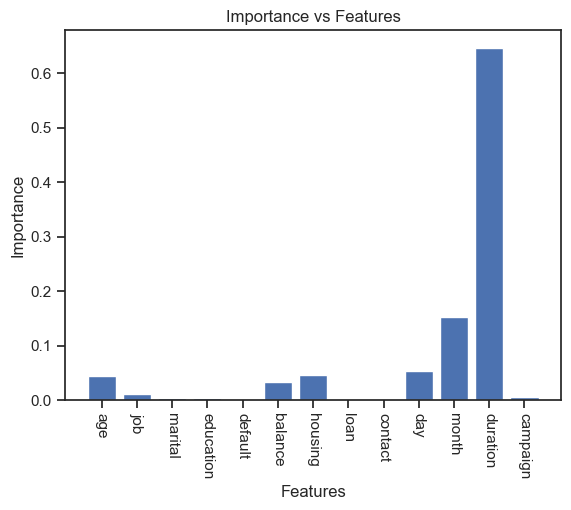


 <<< -------------------------------------------------- >>> 

RandomForestClassifier
Feature: age, Score: 0.04675945889487127
Feature: job, Score: 0.01355243427990785
Feature: marital, Score: 0.006918705869285635
Feature: education, Score: 0.01282088919155821
Feature: default, Score: 0.0004528813444273612
Feature: balance, Score: 0.046035333238881586
Feature: housing, Score: 0.029714961682801702
Feature: loan, Score: 0.0033007627117295404
Feature: contact, Score: 0.003275588679908187
Feature: day, Score: 0.04345342079455591
Feature: month, Score: 0.09223933707209225
Feature: duration, Score: 0.6871743733242328
Feature: campaign, Score: 0.014301852915747607


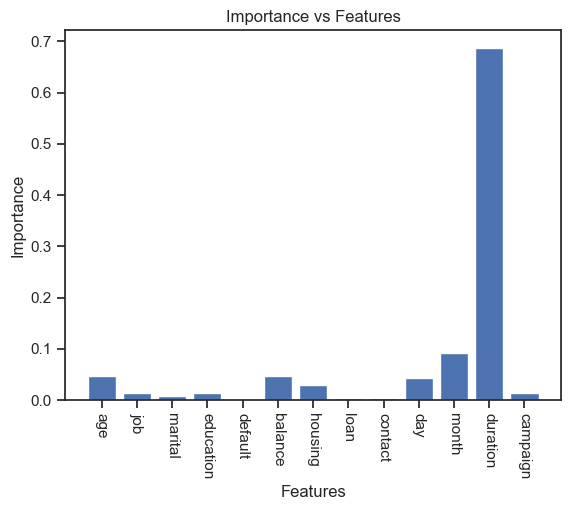


 <<< -------------------------------------------------- >>> 

XGBClassifier
Feature: age, Score: 0.037709981203079224
Feature: job, Score: 0.02347521111369133
Feature: marital, Score: 0.020667806267738342
Feature: education, Score: 0.04963076859712601
Feature: default, Score: 0.0
Feature: balance, Score: 0.03067416325211525
Feature: housing, Score: 0.12229928374290466
Feature: loan, Score: 0.034687936305999756
Feature: contact, Score: 0.011569066904485226
Feature: day, Score: 0.04609597474336624
Feature: month, Score: 0.1425381898880005
Feature: duration, Score: 0.4554022550582886
Feature: campaign, Score: 0.025249306112527847


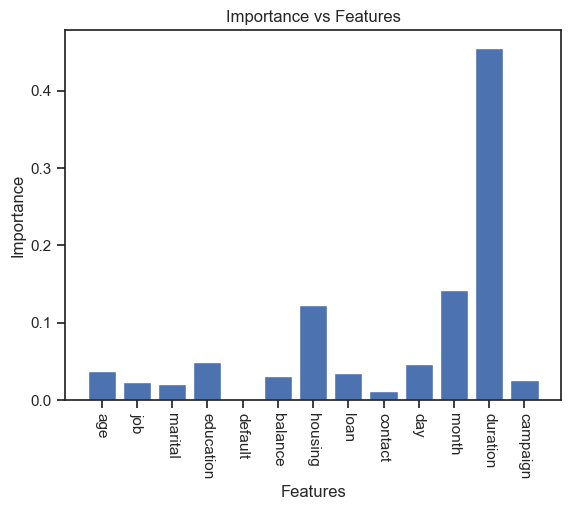


 <<< -------------------------------------------------- >>> 

CatBoostClassifier
Feature: age, Score: 5.873383522070849
Feature: job, Score: 4.0645743274056505
Feature: marital, Score: 2.1180988189102514
Feature: education, Score: 3.3954352410673656
Feature: default, Score: 0.2160584869349229
Feature: balance, Score: 7.924225031255042
Feature: housing, Score: 4.364874993099175
Feature: loan, Score: 1.0477740439610057
Feature: contact, Score: 0.5760753728924956
Feature: day, Score: 12.300744117127058
Feature: month, Score: 22.230008938692027
Feature: duration, Score: 32.602317346600024
Feature: campaign, Score: 3.2864297599841112


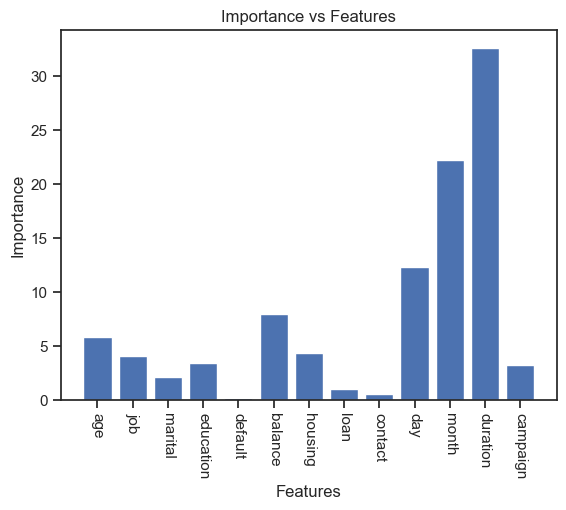


 <<< -------------------------------------------------- >>> 

LGBMClassifier
Feature: age, Score: 374
Feature: job, Score: 104
Feature: marital, Score: 60
Feature: education, Score: 75
Feature: default, Score: 17
Feature: balance, Score: 548
Feature: housing, Score: 71
Feature: loan, Score: 27
Feature: contact, Score: 37
Feature: day, Score: 486
Feature: month, Score: 390
Feature: duration, Score: 719
Feature: campaign, Score: 152


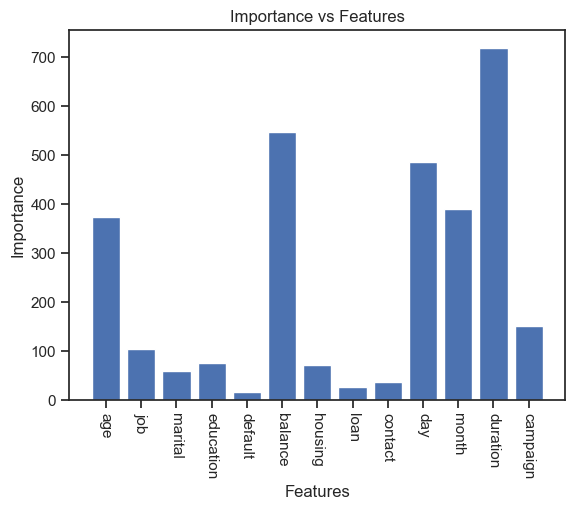


 <<< -------------------------------------------------- >>> 



In [43]:
# Using model attributes
for model in models:
    print_bold(model.__class__.__name__)
    feat_import_tree(model)
    barrier()

### Permutation feature importance
- Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset.
- This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score.
- By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature. [1].

**Ref:**
1. https://scikit-learn.org/stable/modules/permutation_importance.html

In [44]:
# Permutation feature importance
def feat_import_perm(model):
    results = permutation_importance(model, X_train, y_train, scoring="accuracy")
    importance = results.importances_mean
    for i, v in zip(features, importance):
        print(f"Feature: {i}, Score: {v}")
    plt.bar(features, importance)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Importance vs Features")
    plt.xticks(rotation=-90)
    plt.show()

DecisionTreeClassifier
Feature: age, Score: 0.024469659595461258
Feature: job, Score: 0.01055747409965464
Feature: marital, Score: 0.0073014306857424275
Feature: education, Score: 0.0019240256536752875
Feature: default, Score: 0.0
Feature: balance, Score: 0.02259496793290574
Feature: housing, Score: 0.018796250616674826
Feature: loan, Score: 0.0014306857424764674
Feature: contact, Score: 0.0
Feature: day, Score: 0.03917118894918594
Feature: month, Score: 0.06980759743463238
Feature: duration, Score: 0.33053774050320667
Feature: campaign, Score: 0.0022693635915144615


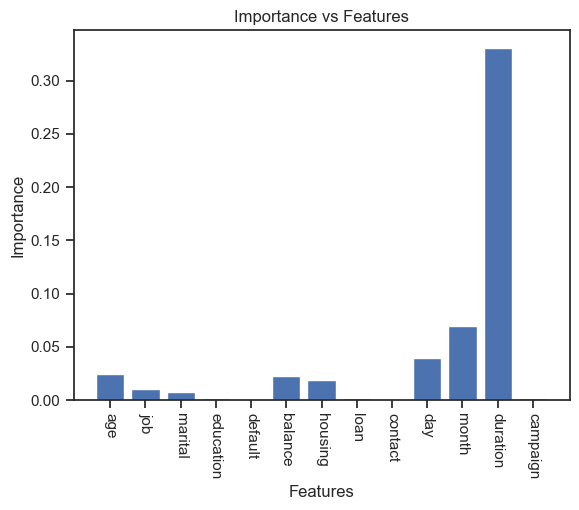


 <<< -------------------------------------------------- >>> 

RandomForestClassifier
Feature: age, Score: 0.016822890971879657
Feature: job, Score: 0.003601381351751387
Feature: marital, Score: 0.005229403058707493
Feature: education, Score: 0.006956092747903364
Feature: default, Score: 4.933399111988202e-05
Feature: balance, Score: 0.0145041933892452
Feature: housing, Score: 0.016773556980759774
Feature: loan, Score: 0.0017760236803157526
Feature: contact, Score: 0.0012826837691169324
Feature: day, Score: 0.02012826837691175
Feature: month, Score: 0.0534287123828318
Feature: duration, Score: 0.33759250123334983
Feature: campaign, Score: 0.004193389245189971


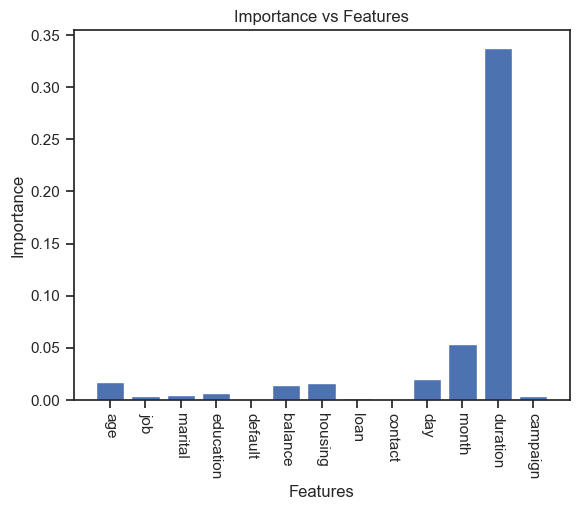


 <<< -------------------------------------------------- >>> 

XGBClassifier
Feature: age, Score: 0.01179082387765169
Feature: job, Score: 0.0022200296003946907
Feature: marital, Score: 0.0004933399111988201
Feature: education, Score: 0.0027627035027133926
Feature: default, Score: 0.0
Feature: balance, Score: 0.0077454366058213875
Feature: housing, Score: 0.022002960039467178
Feature: loan, Score: 0.004982733103108083
Feature: contact, Score: -4.933399111988202e-05
Feature: day, Score: 0.022397631968426236
Feature: month, Score: 0.05377405032067095
Feature: duration, Score: 0.3275777010360138
Feature: campaign, Score: -0.00014800197335964604


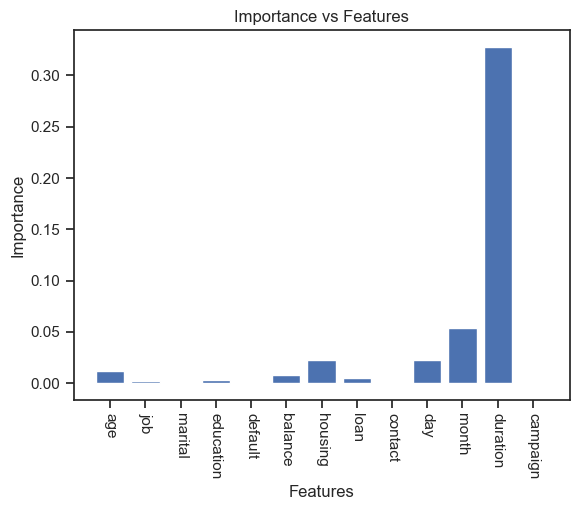


 <<< -------------------------------------------------- >>> 

CatBoostClassifier
Feature: age, Score: 0.02131228416378881
Feature: job, Score: 0.013616181549087326
Feature: marital, Score: 0.006364084854464691
Feature: education, Score: 0.013418845584607797
Feature: default, Score: 0.0007893438579181123
Feature: balance, Score: 0.029205722742969932
Feature: housing, Score: 0.017168228909718808
Feature: loan, Score: 0.003552047360631483
Feature: contact, Score: 0.002417365564874219
Feature: day, Score: 0.061864824864331515
Feature: month, Score: 0.10547607301430686
Feature: duration, Score: 0.35318204242723233
Feature: campaign, Score: 0.01055747409965464


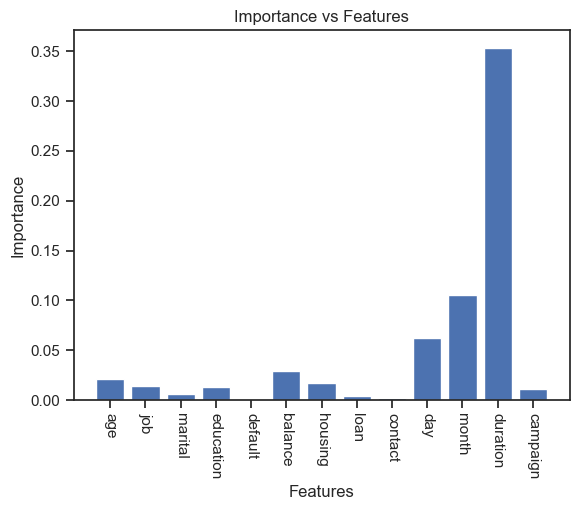


 <<< -------------------------------------------------- >>> 

LGBMClassifier
Feature: age, Score: 0.017316230883078477
Feature: job, Score: 0.006314750863344898
Feature: marital, Score: 0.003256043413912213
Feature: education, Score: 0.00888011840157874
Feature: default, Score: 0.0008386778490379942
Feature: balance, Score: 0.026344351258016773
Feature: housing, Score: 0.00907745436605827
Feature: loan, Score: 0.003206709422792331
Feature: contact, Score: 0.0003453379378391741
Feature: day, Score: 0.06023680315737547
Feature: month, Score: 0.10172668968919593
Feature: duration, Score: 0.3472126295017267
Feature: campaign, Score: 0.006462752836704544


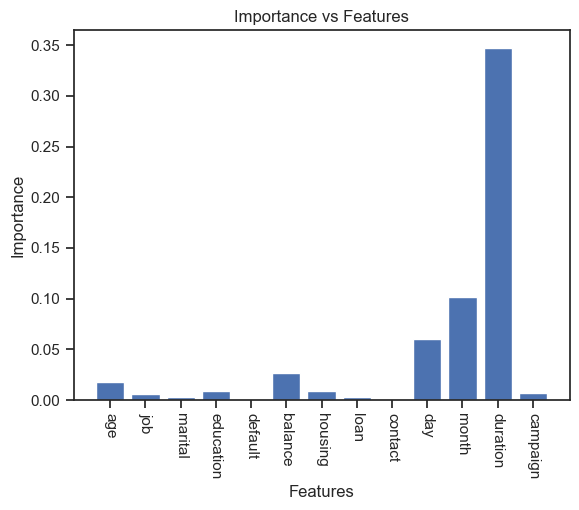


 <<< -------------------------------------------------- >>> 



In [45]:
# Permutation feature importances
for model in models:
    print_bold(model.__class__.__name__)
    feat_import_perm(model)
    barrier()

### Recursive feature elimination (RFE)
- The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
- First, the estimator is trained on the initial set of features and the importance of each feature is obtained through the model attributes.
- Then, the least important features are pruned from current set of features.
- That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached [1].

**Ref:**
1. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [46]:
# RFE
for model in models:
    print_bold(model.__class__.__name__)
    rfe = RFE(model, n_features_to_select=1)
    rfe.fit(X_train, y_train)
    for i, j in (sorted(zip(rfe.ranking_ , features), key=lambda item:item[0])):
        print(i, j)
    barrier()

DecisionTreeClassifier
1 duration
2 month
3 age
4 day
5 housing
6 balance
7 job
8 campaign
9 marital
10 education
11 loan
12 contact
13 default

 <<< -------------------------------------------------- >>> 

RandomForestClassifier
1 duration
2 month
3 age
4 day
5 balance
6 housing
7 job
8 campaign
9 education
10 marital
11 loan
12 contact
13 default

 <<< -------------------------------------------------- >>> 

XGBClassifier
1 duration
2 month
3 housing
4 day
5 education
6 loan
7 age
8 balance
9 campaign
10 job
11 marital
12 contact
13 default

 <<< -------------------------------------------------- >>> 

CatBoostClassifier
1 month
2 duration
3 day
4 balance
5 age
6 housing
7 job
8 campaign
9 education
10 marital
11 loan
12 contact
13 default

 <<< -------------------------------------------------- >>> 

LGBMClassifier
1 balance
2 duration
3 day
4 age
5 month
6 job
7 campaign
8 housing
9 education
10 marital
11 contact
12 loan
13 default

 <<< -------------------------------------------

### RFE cross validation (RFECV)
- RFE cross validation (RFECV) combines the RFE above with cross validation and gives the best combination of features that maximizes the accuracy with the smallest possible number of features.
- The number of features selected is tuned automatically by fitting an RFE selector on the different cross-validation splits (provided by the cv parameter).
- The performance of the RFE selector are evaluated using scorer for different number of selected features and aggregated together.
- Finally, the scores are averaged across folds and the number of features selected is set to the number of features that maximize the cross-validation score [1].

**Ref:**
1. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [47]:
# # RFECV
# for model in models:
#     print_bold(model.__class__.__name__)
#     rfecv = RFECV(estimator=model, step=1, cv=5, scoring="accuracy")
#     rfecv = rfecv.fit(X_train, y_train)
#     print("Optimal number of features :", rfecv.n_features_)
#     print("Best features :", X_train.columns[rfecv.support_])
#     barrier()

#### Important note

- The code cell above takes a significant amount of time to run and, as such, has been commented out.
- Feel free to uncomment and then run the code cell at your leisure.
- The output from the cell was copied and pasted below.

**DecisionTreeClassifier**
Optimal number of features : 4
Best features : Index(['balance', 'day', 'month', 'duration'], dtype='object')

 <<< -------------------------------------------------- >>> 

**RandomForestClassifier**
Optimal number of features : 12
Best features : Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign'],
      dtype='object')

 <<< -------------------------------------------------- >>> 

**XGBClassifier**
Optimal number of features : 6
Best features : Index(['age', 'education', 'housing', 'day', 'month', 'duration'], dtype='object')

 <<< -------------------------------------------------- >>> 

**CatBoostClassifier**
Optimal number of features : 11
Best features : Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign'],
      dtype='object')

 <<< -------------------------------------------------- >>> 

**LGBMClassifier**
Optimal number of features : 10
Best features : Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'day',
       'month', 'duration', 'campaign'],
      dtype='object')

 <<< -------------------------------------------------- >>> 

### Inference for feature importance

**NOTE:**
- Across all methods and models, there are clearly significant variations in feature importance but the most standout feature appear to be `duration` by a significant margin.
- The features `month`, `day`, `housing`, `balance`, `age` also show importance to a lesser but still significant degree.

## Customer segmentation

In [48]:
# A reminder of the different dataframes we have created so far
display(df.head())
barrier()
display(df_enc.head())
barrier()
display(df_enc_balanced.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,no
3,47,blue-collar,married,primary,no,1506,yes,no,cellular,5,may,92,1,no
4,33,admin,single,tertiary,no,1,no,no,cellular,5,may,198,1,no



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,0,5,8,261,1,0
1,44,9,2,1,0,29,1,0,0,5,8,151,1,0
2,33,2,1,1,0,2,1,1,0,5,8,76,1,0
3,47,1,1,0,0,1506,1,0,0,5,8,92,1,0
4,33,0,2,2,0,1,0,0,0,5,8,198,1,0



 <<< -------------------------------------------------- >>> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,59,0,1,1,0,2343,1,0,0,5,8,1042,1,1
1,56,0,1,1,0,45,0,0,0,5,8,1467,1,1
2,41,9,1,1,0,1270,1,0,0,5,8,1389,1,1
3,55,7,1,1,0,2476,1,0,0,5,8,579,1,1
4,54,0,1,2,0,184,0,0,0,5,8,673,2,1


In [49]:
# A reminder of the different dataframes we have created so far
display(df.info())
barrier()
display(df_enc.info())
barrier()
display(df_enc_balanced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


None


 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int32
 2   marital    40000 non-null  int32
 3   education  40000 non-null  int32
 4   default    40000 non-null  int32
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int32
 7   loan       40000 non-null  int32
 8   contact    40000 non-null  int32
 9   day        40000 non-null  int64
 10  month      40000 non-null  int32
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int32
dtypes: int32(9), int64(5)
memory usage: 2.9 MB


None


 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        5792 non-null   int64
 1   job        5792 non-null   int32
 2   marital    5792 non-null   int32
 3   education  5792 non-null   int32
 4   default    5792 non-null   int32
 5   balance    5792 non-null   int64
 6   housing    5792 non-null   int32
 7   loan       5792 non-null   int32
 8   contact    5792 non-null   int32
 9   day        5792 non-null   int64
 10  month      5792 non-null   int32
 11  duration   5792 non-null   int64
 12  campaign   5792 non-null   int64
 13  y          5792 non-null   int32
dtypes: int32(9), int64(5)
memory usage: 430.0 KB


None

In [50]:
# Df with only the yes values present
df_yes = df[df["y"]=="yes"]
df_yes

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
83,59,admin,married,secondary,no,2343,yes,no,cellular,5,may,1042,1,yes
86,56,admin,married,secondary,no,45,no,no,cellular,5,may,1467,1,yes
87,41,technician,married,secondary,no,1270,yes,no,cellular,5,may,1389,1,yes
129,55,services,married,secondary,no,2476,yes,no,cellular,5,may,579,1,yes
168,54,admin,married,tertiary,no,184,no,no,cellular,5,may,673,2,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39986,29,management,single,tertiary,no,637,yes,no,cellular,3,jun,340,1,yes
39988,55,management,divorced,tertiary,no,2383,no,no,cellular,3,jun,591,2,yes
39990,26,technician,single,secondary,no,1231,yes,no,cellular,3,jun,385,2,yes
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes


### Important note
- For **Customer Segmentation**, we will use the entire dataset not just the balanced dataset.
- We will also use each feature individually to predict the target variables and calculate accuracy.
    - This will be done for informational purposes only.

### Numerical

age:


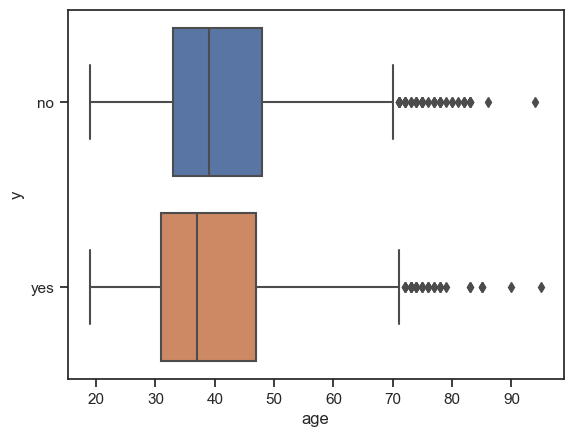

balance:


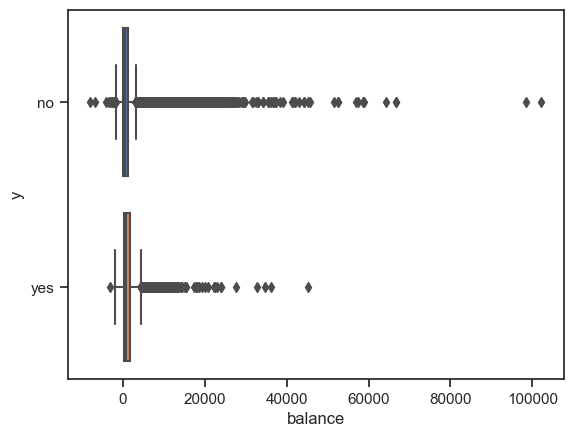

day:


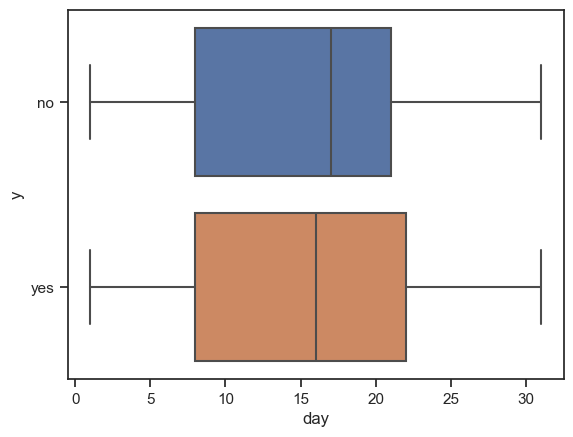

duration:


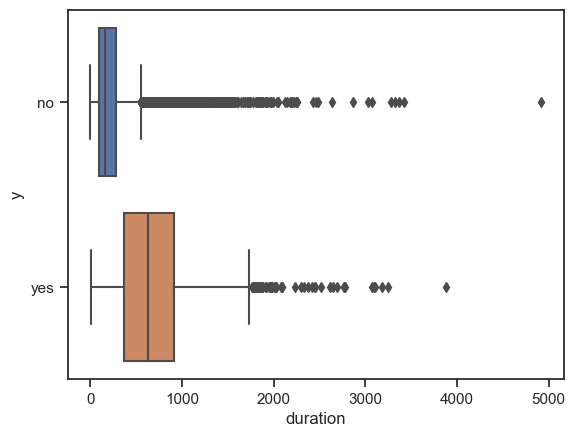

campaign:


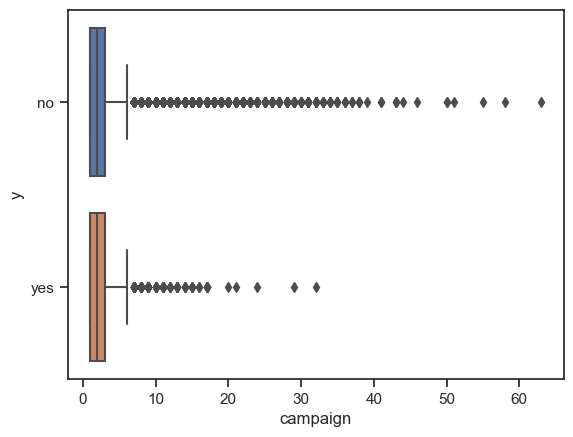

In [51]:
# Numerical features
feats = [feature for feature in df.select_dtypes("int")]

for feat in feats:
    print_bold(f"{feat}:")
    sns.boxplot(data=df, x=feat, y="y")
    plt.show()

**NOTE:**
- Boxplots of the numerical features showed no clear/significant separation between the two classes.

#### Cross val score

In [52]:
# Numerical features - cross val score
feats = [feature for feature in df.select_dtypes("int")]
df_ = df_enc_balanced.copy()

for feat in feats:
    print_bold(feat)
    dtc = DecisionTreeClassifier()
    cross_val = cross_val_score(dtc, df_[[feat]], df_[["y"]], cv=5).mean()
    print(f"Cross val score for {feat}: {cross_val}")
    barrier()

age
Cross val score for age: 0.529526078851252

 <<< -------------------------------------------------- >>> 

balance
Cross val score for balance: 0.511743045714175

 <<< -------------------------------------------------- >>> 

day
Cross val score for day: 0.47859091796423864

 <<< -------------------------------------------------- >>> 

duration
Cross val score for duration: 0.7365044310427815

 <<< -------------------------------------------------- >>> 

campaign
Cross val score for campaign: 0.5274778298843176

 <<< -------------------------------------------------- >>> 



In [53]:
# Numerical features - cross val score
feats = [feature for feature in df.select_dtypes("int")]
df_ = df_enc_balanced.copy()

for feat in feats:
    print_bold(feat)
    xgb = XGBClassifier()
    cross_val = cross_val_score(xgb, df_[feat], df_["y"], cv=5).mean()
    print(f"Cross val score for {feat}: {cross_val}")
    barrier()

age
Cross val score for age: 0.532980310284758

 <<< -------------------------------------------------- >>> 

balance
Cross val score for balance: 0.5189982728842832

 <<< -------------------------------------------------- >>> 

day
Cross val score for day: 0.47859091796423864

 <<< -------------------------------------------------- >>> 

duration
Cross val score for duration: 0.7787979036182999

 <<< -------------------------------------------------- >>> 

campaign
Cross val score for campaign: 0.5269596951692916

 <<< -------------------------------------------------- >>> 



**NOTE:**
- All numerical features, with the exception of `duration`, show a poor cross validated accuracy score when predicting the target feature.

### Categorical

job :


,job,%
management,679,23.45
blue-collar,539,18.61
technician,500,17.27
admin,352,12.15
services,240,8.29
retired,152,5.25
self-employed,113,3.90
unemployed,97,3.35
entrepreneur,89,3.07
student,82,2.83


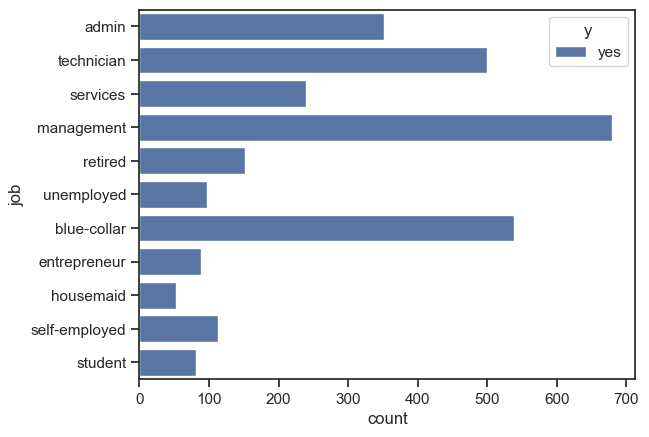


 <<< -------------------------------------------------- >>> 

marital :


,marital,%
married,1478,51.04
single,1027,35.46
divorced,391,13.50


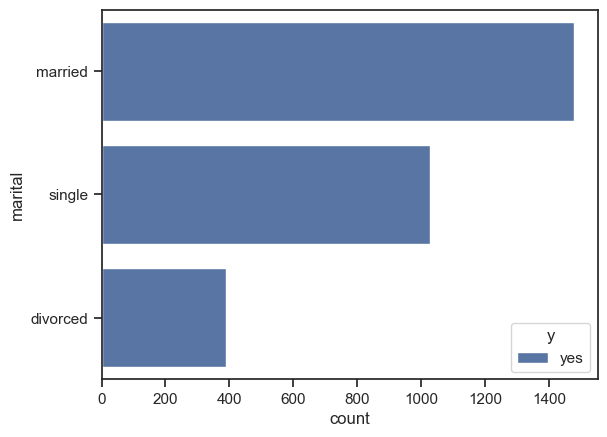


 <<< -------------------------------------------------- >>> 

education :


,education,%
secondary,1473,50.86
tertiary,1054,36.40
primary,369,12.74


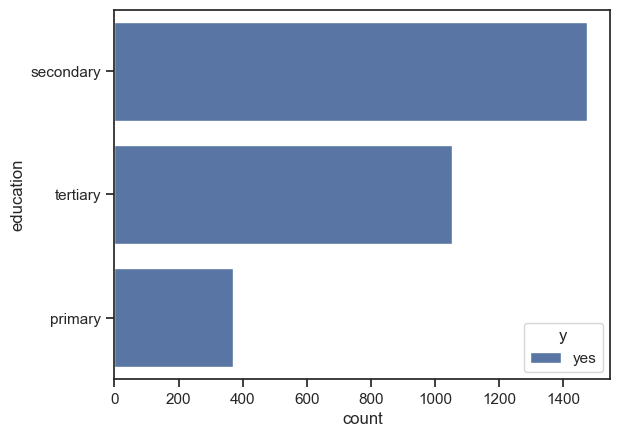


 <<< -------------------------------------------------- >>> 

default :


,default,%
no,2847,98.31
yes,49,1.69


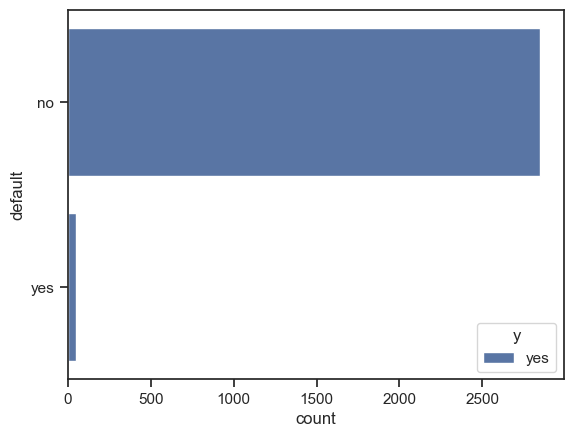


 <<< -------------------------------------------------- >>> 

housing :


,housing,%
yes,1464,50.55
no,1432,49.45


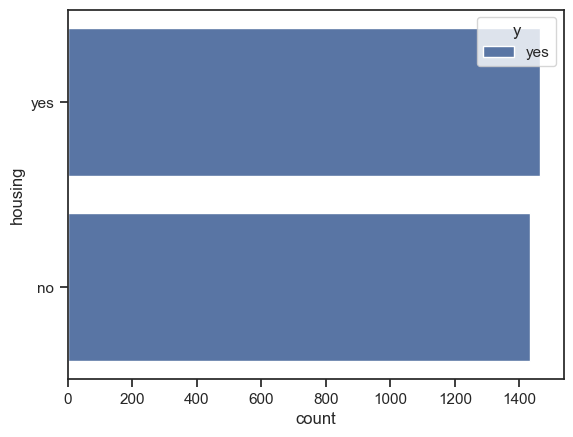


 <<< -------------------------------------------------- >>> 

loan :


,loan,%
no,2516,86.88
yes,380,13.12


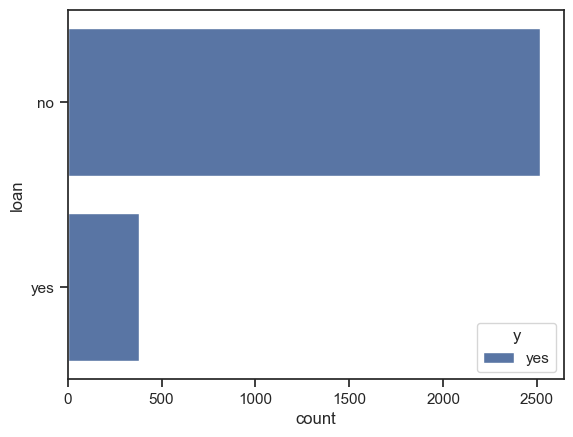


 <<< -------------------------------------------------- >>> 

contact :


,contact,%
cellular,2694,93.02
telephone,202,6.98


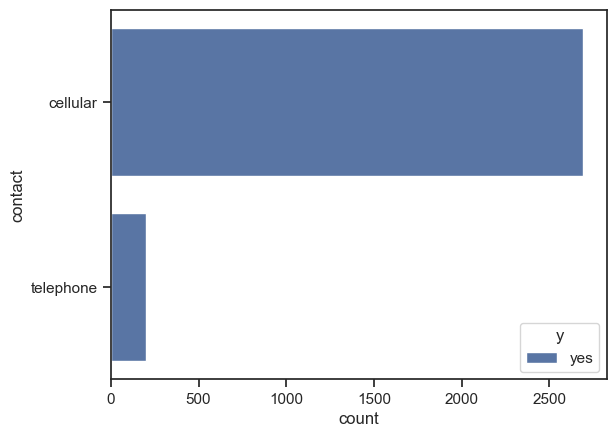


 <<< -------------------------------------------------- >>> 

month :


,month,%
may,791,27.31
apr,451,15.57
jul,384,13.26
jun,294,10.15
aug,288,9.94
feb,255,8.81
nov,220,7.60
mar,125,4.32
oct,49,1.69
jan,38,1.31


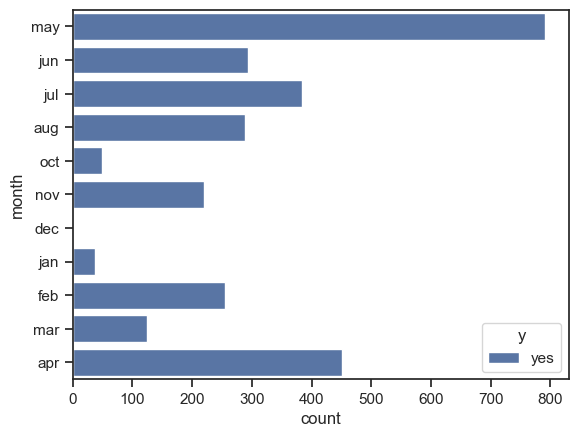


 <<< -------------------------------------------------- >>> 

day :


,day,%
30,224,7.73
18,165,5.70
20,153,5.28
21,139,4.80
15,123,4.25
13,117,4.04
4,117,4.04
17,115,3.97
14,115,3.97
5,113,3.90


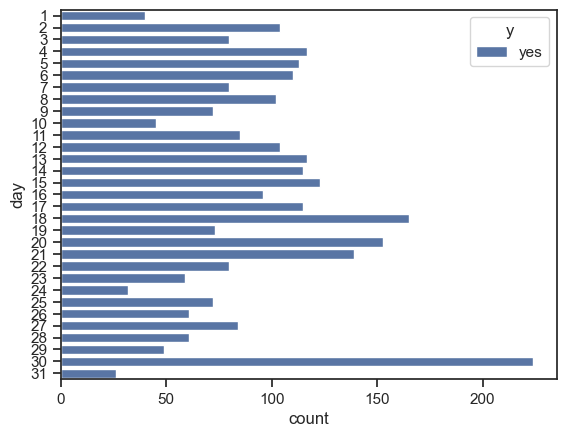


 <<< -------------------------------------------------- >>> 



In [54]:
# Categorical features
feats = [feature for feature in df.select_dtypes("object").columns if feature != "y"]
feats.append("day")

for feat in feats:
    print(bold(feat), ":")
    df_ = pd.DataFrame(df_yes[feat].value_counts())
    df_["%"] = (df_[feat]/df_yes.shape[0]) * 100
    display(df_)
    sns.set(style="ticks", color_codes=True)
    sns.countplot(y=feat, hue="y", data=df_yes)
    plt.show()
    barrier()

In [55]:
# # Categorical features
# feats = [feature for feature in df.select_dtypes("object").columns if feature != "y"]

# for feat in feats:
#     sns.set(style="ticks", color_codes=True)
#     sns.countplot(y=feat, hue="y", data=df)
#     plt.show()

**NOTE:**
- Plots of the features against the target variables seem to suggest that favorable market segments include: **(admin, technician, services, management, blue collar), married, at least secondary school educated, no default, no loan, cellular communicating** customers last called between **April to July** and in **November**.
- The nature of this result would be a topic of conversation during follow up discussions with the client.

#### Cross val score

In [56]:
# Categorical features - cross val score
feats = [feature for feature in df.select_dtypes("object").columns if feature != "y"]
feats.append("day")
df_ = df_enc_balanced.copy()

for feat in feats:
    print_bold(feat)
    dtc = DecisionTreeClassifier()
    cross_val = cross_val_score(dtc, df_[[feat]], df_[["y"]], cv=5).mean()
    print(f"Cross val score for {feat}: {cross_val}")
    barrier()

job
Cross val score for job: 0.5436918551368655

 <<< -------------------------------------------------- >>> 

marital
Cross val score for marital: 0.553695565678828

 <<< -------------------------------------------------- >>> 

education
Cross val score for education: 0.5376448638797366

 <<< -------------------------------------------------- >>> 

default
Cross val score for default: 0.49482059008048446

 <<< -------------------------------------------------- >>> 

housing
Cross val score for housing: 0.5519680029088265

 <<< -------------------------------------------------- >>> 

loan
Cross val score for loan: 0.5184817773645019

 <<< -------------------------------------------------- >>> 

contact
Cross val score for contact: 0.5089790644963721

 <<< -------------------------------------------------- >>> 

month
Cross val score for month: 0.3636003284351199

 <<< -------------------------------------------------- >>> 

day
Cross val score for day: 0.47859091796423864

 <<< -------

In [57]:
# Categorical features - cross val score
feats = [feature for feature in df.select_dtypes("object").columns if feature != "y"]
feats.append("day")
df_ = df_enc_balanced.copy()

for feat in feats:
    print_bold(feat)
    xgb = XGBClassifier()
    cross_val = cross_val_score(xgb, df_[feat], df_["y"], cv=5).mean()
    print(f"Cross val score for {feat}: {cross_val}")
    barrier()

job
Cross val score for job: 0.5476642212853973

 <<< -------------------------------------------------- >>> 

marital
Cross val score for marital: 0.553695565678828

 <<< -------------------------------------------------- >>> 

education
Cross val score for education: 0.5376448638797366

 <<< -------------------------------------------------- >>> 

default
Cross val score for default: 0.49482059008048446

 <<< -------------------------------------------------- >>> 

housing
Cross val score for housing: 0.5519680029088265

 <<< -------------------------------------------------- >>> 

loan
Cross val score for loan: 0.5184817773645019

 <<< -------------------------------------------------- >>> 

contact
Cross val score for contact: 0.5089790644963721

 <<< -------------------------------------------------- >>> 

month
Cross val score for month: 0.3636003284351199

 <<< -------------------------------------------------- >>> 

day
Cross val score for day: 0.47859091796423864

 <<< -------

**NOTE:**
- All categorical features show a poor cross validated accuracy score when predicting the target feature.

### Clustering

#### PCA

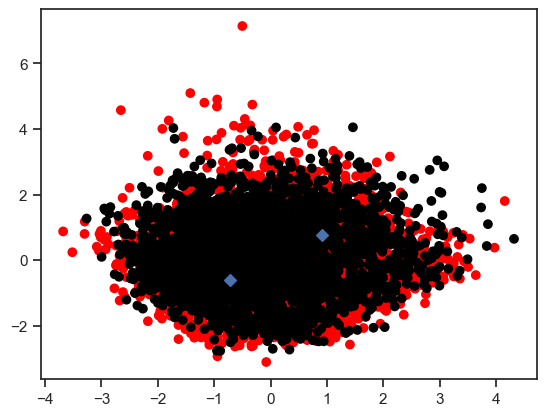

In [58]:
# 2D - Scaling, PCA, KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(2).fit(X_scaled)
X_pca = pca.transform(X_scaled)
model = KMeans(n_clusters=2)
model.fit(X_pca)

# Plot
c = y.replace({0:"black", 1:"red"})
xs = X_pca[:, 0]
ys = X_pca[:, 1]
plt.scatter(xs, ys, c=c)
centroids = model.cluster_centers_
centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]
plt.scatter(centroids_x, centroids_y, marker="D")
plt.show()

In [59]:
# 3D - Scaling, PCA, KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(3).fit(X_scaled)
X_pca = pca.transform(X_scaled)
model = KMeans(n_clusters=2)
model.fit(X_pca)

# Plot
c = y.replace({0:"no", 1:"yes"})
xs = X_pca[:, 0]
ys = X_pca[:, 1]
zs = X_pca[:, 2]
fig = px.scatter_3d(x=xs, y=ys, z=zs, color=c)
fig.show()

#### TSNE

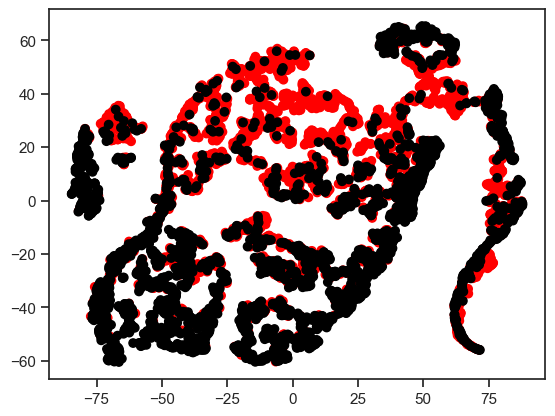

In [60]:
# 2D - TSNE
model = TSNE(learning_rate=200)
tsne_features = model.fit_transform(X)
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]
c = y.replace({0:"black", 1:"red"})
plt.scatter(xs, ys, c=c)
plt.show()

In [61]:
# 3D - TSNE
model = TSNE(learning_rate=200, n_components=3)
tsne_features = model.fit_transform(X)
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]
ys = tsne_features[:, 2]
c = y.replace({0:"no", 1:"yes"})
fig = px.scatter_3d(x=xs, y=ys, z=zs, color=c)
fig.show()

**NOTE:**
- 2D and 3D plots of the dataset using both **PCA feature reduction** and **TSNE feature reduction** show no linear separability.
- No further insight was provided by clustering.

## Final conclusion & Inference

**Feature importance:**
- Across all methods and models, there are clearly significant variations in feature importance.
- The most standout **numerical** feature appear to be `duration` by a significant margin.
- The features `month`, `day`, `housing`, `balance`, `age` also show importance to a lesser but still significant degree.
- This was further bolstered by the result of using cross validation scores (in the Customer segmentation section) calculated using each feature individually to predict the target variable.
    - Here, only the `duration` feature (**~74% accuracy**) showed a result that was significantly better than random guessing (50% accuracy).
- At the same time, the categorical feature analysis suggested that the favorable market segments include: **(admin, technician, services, management, blue collar), married, at least secondary school educated, no default, no loan, cellular communicating** customers last called between **April to July** and in **November**.
- The nature of this result would be a topic of conversation during follow up discussions with the client.

**Customer segmentation:**
- The box plots of the numerical features showed no clear separation/distinction with regards to the likelihood of subscribing to a term deposit.

**Clustering:**
- The data was reduced using both PCA and TSNE into both 2D and 3D datasets.
- In each case, the data was was then clustered and plotted but there was no clear separation/distinction with regards to the likelihood of subscribing to a term deposit.

**See notebook_1.ipynb for:**
- Data wrangling
- Exploratory Data Analysis
- Data visualization
- Preprocessing and Training
- Modeling